# Sentiment analysis using RNN and word embedding

### Summary :

- [Importing data](#1)
- [Preprocessing](#2)
- [Tokenizer](#3)
- [Split of train and test data](#4)
- [Compile the model and evaluate it](#5)

Database at https://www.kaggle.com/kazanova/sentiment140

This notebook is written in Python3, the goal was to analyse a 16.000.000 tweet dataset using RNN and word embedding to do sentiment analysis

The notebook is organised like this : titles are in bold typo and shortcuts are available in the summary, explainations about what we are doing are in comments (markdowns) and notes of few things I tried and worked with but didn't actually work in the end are in brut text (for NBconvert) and the code inside it wont compute

And here we go !

## 0. Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import string
import re
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import sequence
import keras
from keras.layers import LSTM, Activation, Dropout, Dense, Input, Embedding
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import nltk
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/victorgaya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

<a name="1"></a>
## 1. Importing data

Importing file data.csv with all the tweets

In [2]:
data = pd.read_csv("../data/data.csv", sep=',', encoding = 'latin', header=None)

data

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


I tried to take only 1000 positive and 1000 negative tweets to get faster calculation just taking from the middle of the dataset but all the time I was trying to compile the model it didn't work, I finaly used the iloc function from the pandas library (few lines later) to be able to use less tweets and for my model to run properly

We can rename the columns for better understanding

In [3]:
data.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
data.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


As we don't need all the columns, let's drop the ones we don't want

In [4]:
data = data[['text','sentiment']]
data.head()

,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


We separate positive and negative tweets

In [5]:
pos = data[data.sentiment == 4]
neg = data[data.sentiment == 0]

We take only 10000 positive and 10000 negative tweets to get faster calculation

In [6]:
pos = pos.iloc[:int(10000)]
neg = neg.iloc[:int(10000)]

We assign 1 to positive instead of 4 so it makes our testing possible later

In [7]:
pos.sentiment = 1

We concatenate positive and negative tweets

In [8]:
data = pd.concat([pos, neg])

data

,text,sentiment
800000,I LOVE @Health4UandPets u guys r the best!!,1
800001,im meeting up with one of my besties tonight! ...,1
800002,"@DaRealSunisaKim Thanks for the Twitter add, S...",1
800003,Being sick can be really cheap when it hurts t...,1
800004,@LovesBrooklyn2 he has that effect on everyone,1
...,...,...
9995,Aww that's sad,0
9996,stupid dvds stuffing up the good bits in jaws.,0
9997,@Dandy_Sephy No. Only close friends and family...,0
9998,CRAP! After looking when I last tweeted... WHY...,0


In the .csv, the tweets with negative meaning is labeled as a 0, and positive as a 4, so we will replace 0 with word negative, 4 with the word positive for better understanding of the dataset

<a name="2"></a>
## 2. Preprocessing

To start preprocessing, we want to make our tweets in lower case

In [9]:
data.text=data.text.str.lower()

data.text.head()

800000         i love @health4uandpets u guys r the best!! 
800001    im meeting up with one of my besties tonight! ...
800002    @darealsunisakim thanks for the twitter add, s...
800003    being sick can be really cheap when it hurts t...
800004      @lovesbrooklyn2 he has that effect on everyone 
Name: text, dtype: object

To preprocess our data, we will want to lemmatize and to remove stop words to keep only the most important of our tweets

In [10]:
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in nltk.corpus.stopwords.words('english')])

In [11]:
data.text = data.text.apply(lambda x: remove_stopwords(x))

In [12]:
data.text

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
                                ...                        
9995                                         aww that's sad
9996                   stupid dvds stuffing good bits jaws.
9997      @dandy_sephy no. close friends family i'm afra...
9998      crap! looking last tweeted... early. 10! like....
9999                                   another rainboot day
Name: text, Length: 20000, dtype: object

Next we want to remove the characters which are repeated in the words so it is even cleaner

In [13]:
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [14]:
data.text = data.text.apply(lambda x: remove_repeating_char(x))

In [15]:
data.text

800000                 love @health4uandpets u guys r best!
800001    im meting one besties tonight! cant wait! - gi...
800002    @darealsunisakim thanks twiter ad, sunisa! got...
800003    sick realy cheap hurts much eat real fod plus,...
800004                        @lovesbroklyn2 efect everyone
                                ...                        
9995                                          aw that's sad
9996                     stupid dvds stufing god bits jaws.
9997      @dandy_sephy no. close friends family i'm afra...
9998         crap! loking last tweted. early. 10! like. 12.
9999                                    another rainbot day
Name: text, Length: 20000, dtype: object

Then we want to clean and remove names or emails, which are always after the symbol "@"

In [16]:
def remove_at(data):
    return re.sub('@[^\s]+', ' ', data)

In [17]:
data.text = data.text.apply(lambda x: remove_at(x))

In [18]:
data.text

800000                                love   u guys r best!
800001    im meting one besties tonight! cant wait! - gi...
800002      thanks twiter ad, sunisa! got met hin show d...
800003    sick realy cheap hurts much eat real fod plus,...
800004                                       efect everyone
                                ...                        
9995                                          aw that's sad
9996                     stupid dvds stufing god bits jaws.
9997        no. close friends family i'm afraid. i'm wor...
9998         crap! loking last tweted. early. 10! like. 12.
9999                                    another rainbot day
Name: text, Length: 20000, dtype: object

We now clean and remove URLs

In [19]:
def remove_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

In [20]:
data.text = data.text.apply(lambda x: remove_URLs(x))

In [21]:
data.text

800000                                love   u guys r best!
800001    im meting one besties tonight! cant wait! - gi...
800002      thanks twiter ad, sunisa! got met hin show d...
800003    sick realy cheap hurts much eat real fod plus,...
800004                                       efect everyone
                                ...                        
9995                                          aw that's sad
9996                     stupid dvds stufing god bits jaws.
9997        no. close friends family i'm afraid. i'm wor...
9998         crap! loking last tweted. early. 10! like. 12.
9999                                    another rainbot day
Name: text, Length: 20000, dtype: object

Now removing numeric numbers

In [22]:
def remove_numbers(data):
    return re.sub('[0-9]+', '', data)

In [23]:
data.text = data.text.apply(lambda x: remove_numbers(x))

In [24]:
data.text

800000                                love   u guys r best!
800001    im meting one besties tonight! cant wait! - gi...
800002      thanks twiter ad, sunisa! got met hin show d...
800003    sick realy cheap hurts much eat real fod plus,...
800004                                       efect everyone
                                ...                        
9995                                          aw that's sad
9996                     stupid dvds stufing god bits jaws.
9997        no. close friends family i'm afraid. i'm wor...
9998             crap! loking last tweted. early. ! like. .
9999                                    another rainbot day
Name: text, Length: 20000, dtype: object

In [25]:
def remove_punctuations(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [26]:
data.text = data.text.apply(lambda x: remove_punctuations(x))

In [27]:
data.text

800000                                 love   u guys r best
800001    im meting one besties tonight cant wait  girl ...
800002      thanks twiter ad sunisa got met hin show dc ...
800003    sick realy cheap hurts much eat real fod plus ...
800004                                       efect everyone
                                ...                        
9995                                           aw thats sad
9996                      stupid dvds stufing god bits jaws
9997        no close friends family im afraid im work co...
9998                   crap loking last tweted early  like 
9999                                    another rainbot day
Name: text, Length: 20000, dtype: object

<a name="3"></a>
## 3. Tokenizer

Tokenization of tweets text

In [28]:
tokenizer = RegexpTokenizer(r'\w+')
data.text = data.text.apply(tokenizer.tokenize)

In [29]:
data.text

800000                             [love, u, guys, r, best]
800001    [im, meting, one, besties, tonight, cant, wait...
800002    [thanks, twiter, ad, sunisa, got, met, hin, sh...
800003    [sick, realy, cheap, hurts, much, eat, real, f...
800004                                    [efect, everyone]
                                ...                        
9995                                       [aw, thats, sad]
9996               [stupid, dvds, stufing, god, bits, jaws]
9997      [no, close, friends, family, im, afraid, im, w...
9998              [crap, loking, last, tweted, early, like]
9999                                [another, rainbot, day]
Name: text, Length: 20000, dtype: object

We can now apply stemming

In [30]:
def stemming_data(data):
    text = [nltk.PorterStemmer().stem(word) for word in data]
    return data

In [31]:
data.text = data.text.apply(lambda x: stemming_data(x))

In [32]:
data.text

800000                             [love, u, guys, r, best]
800001    [im, meting, one, besties, tonight, cant, wait...
800002    [thanks, twiter, ad, sunisa, got, met, hin, sh...
800003    [sick, realy, cheap, hurts, much, eat, real, f...
800004                                    [efect, everyone]
                                ...                        
9995                                       [aw, thats, sad]
9996               [stupid, dvds, stufing, god, bits, jaws]
9997      [no, close, friends, family, im, afraid, im, w...
9998              [crap, loking, last, tweted, early, like]
9999                                [another, rainbot, day]
Name: text, Length: 20000, dtype: object

And finaly we apply the lemmatizer

In [33]:
def lemmatizing_data(data):
    text = [nltk.WordNetLemmatizer().lemmatize(word) for word in data]
    return data

In [34]:
data.text = data.text.apply(lambda x: lemmatizing_data(x))

In [35]:
data.text

800000                             [love, u, guys, r, best]
800001    [im, meting, one, besties, tonight, cant, wait...
800002    [thanks, twiter, ad, sunisa, got, met, hin, sh...
800003    [sick, realy, cheap, hurts, much, eat, real, f...
800004                                    [efect, everyone]
                                ...                        
9995                                       [aw, thats, sad]
9996               [stupid, dvds, stufing, god, bits, jaws]
9997      [no, close, friends, family, im, afraid, im, w...
9998              [crap, loking, last, tweted, early, like]
9999                                [another, rainbot, day]
Name: text, Length: 20000, dtype: object

<a name="4"></a>
## 4. Split of train and test data

We want to shuffle the dataset for it to be randomized, train_test_split will shuffle the dataset for us and split it to gives training and testing dataset.

First we separate the dataset

In [36]:
x=data.text
y=data.sentiment

We will now prepare the input features for training 

We convert the text words into a matrix with a maximum of 300 features per word selected for the training

In [37]:
MAX_SEQUENCE_LENGTH = 500
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
matrix = sequence.pad_sequences(sequences,maxlen=MAX_SEQUENCE_LENGTH)

In [38]:
matrix.shape

(20000, 500)

Here we use train_test_split to have our data splited for the training and testing, x being the text and y the sentiment

In [39]:
x_train, x_test, y_train, y_test = train_test_split(matrix, y, test_size=0.3, random_state=2)

We now define our model, we will use Keras, which will be made of an input layer, an embedding layer, then LSTM, a dense layer, an activation using ReLU, then the dropout and an other dense layer before finishing with a last layer of activation using sigmoid this time.

In [40]:
def tensorflow_model():
    inputs = Input(name='inputs',shape=[MAX_SEQUENCE_LENGTH])
    layer = Embedding(2000,50,input_length=MAX_SEQUENCE_LENGTH)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

<a name="5"></a>
## 5. Compile the model and evaluate it

We want to call our model, so will be using 2 classes, if we set "binary_crossentropy" and use more than two classes then we will be using "categorical_crossentropy" 

We can change the features of neural network such as learning rate with the optimizer function in order to reduce the losses. 

In [41]:
model = tensorflow_model()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

We will now train and validate the model with parameter tuning

In [42]:
history = model.fit(x_train,y_train,batch_size=80,epochs=15, validation_split=0.1)

Epoch 1/15
158/158 [==============================] - 49s 296ms/step - loss: 0.6537 - accuracy: 0.6017 - val_loss: 0.5515 - val_accuracy: 0.7171
Epoch 2/15
158/158 [==============================] - 50s 319ms/step - loss: 0.4882 - accuracy: 0.7648 - val_loss: 0.5583 - val_accuracy: 0.7150
Epoch 3/15
158/158 [==============================] - 47s 297ms/step - loss: 0.4662 - accuracy: 0.7804 - val_loss: 0.5620 - val_accuracy: 0.7164
Epoch 4/15
158/158 [==============================] - 48s 306ms/step - loss: 0.4461 - accuracy: 0.7878 - val_loss: 0.5627 - val_accuracy: 0.7071
Epoch 5/15
158/158 [==============================] - 49s 309ms/step - loss: 0.4272 - accuracy: 0.8008 - val_loss: 0.5752 - val_accuracy: 0.7014
Epoch 6/15
158/158 [==============================] - 49s 309ms/step - loss: 0.4272 - accuracy: 0.8071 - val_loss: 0.6040 - val_accuracy: 0.7007
Epoch 7/15
158/158 [==============================] - 49s 310ms/step - loss: 0.5532 - accuracy: 0.7775 - val_loss: 0.6171 - val_ac

Testing the Trained model on test data

In [43]:
accuracy = model.evaluate(x_test,y_test) #we are starting to test the model here

print('Accuracy: ', accuracy[1])

188/188 [==============================] - 10s 54ms/step - loss: 0.8117 - accuracy: 0.7020
Accuracy:  0.7020000219345093


Now we want to plot our accuracy and loss to see graphically how good our model is

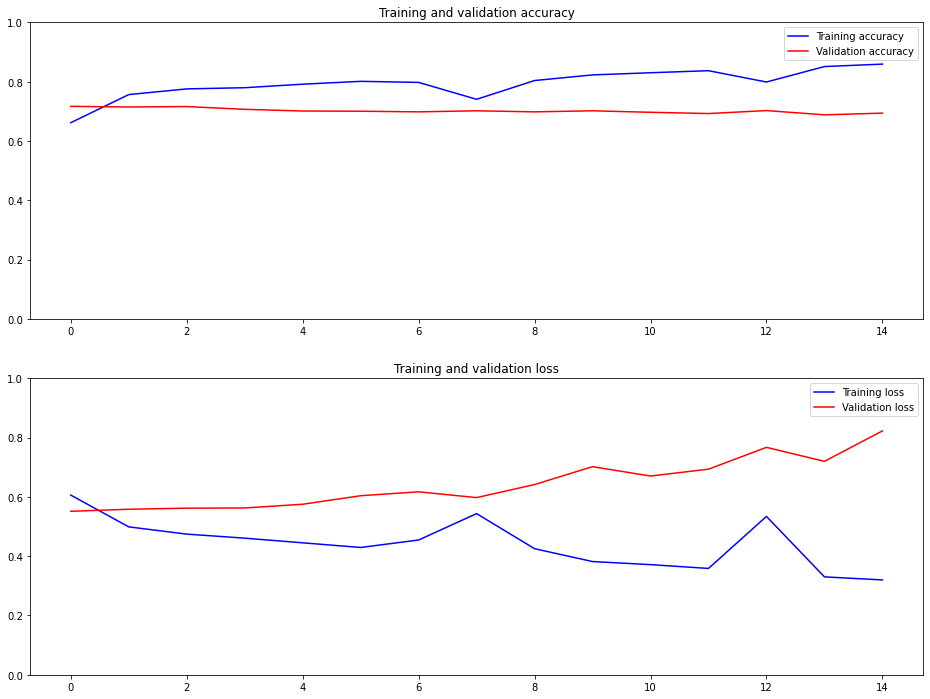

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.figure(figsize=(16,12))
plt.subplot(2,1,1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylim([0,1])
plt.legend()

plt.subplot(2,1,2) 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.ylim([0,1])
plt.legend()
 
plt.show()

An other way to evaluate our model is to build a confusion matrix, so first we have get the prediction, and then plot it in a confusion matrix (to have fast results we will use directly the sklearn.metrics library here)

In [45]:
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5)

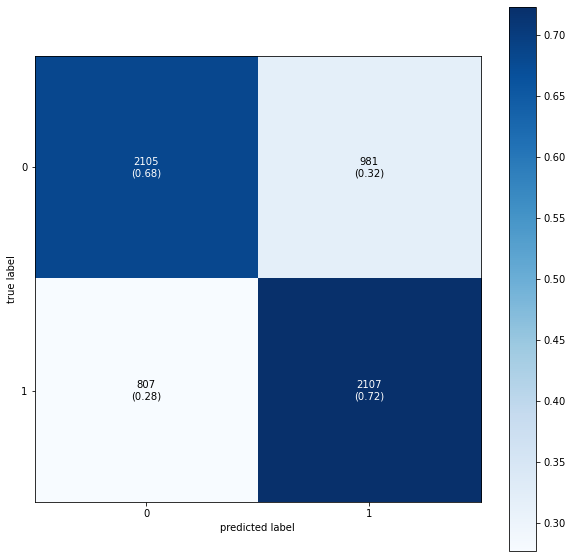

In [46]:
fig, ax = plot_confusion_matrix(conf_mat= confusion_matrix(y_test, y_pred),figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()